## NLP and Naive Baysian Classifier to Identify Class of Genetic Mutation from Clinical Text for Precision Medicine

The data is from Kaggle Competition:
https://www.kaggle.com/c/msk-redefining-cancer-treatment/data

In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import nltk
#nltk.download()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
train_variants = pd.read_csv("data/training_variants")
test_variants = pd.read_csv("data/test_variants")
train_text = pd.read_csv("data/training_text", sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
test_text = pd.read_csv("data/test_text", sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])

print("Train Variant".ljust(15), train_variants.shape)
print("Train Text".ljust(15), train_text.shape)
print("Test Variant".ljust(15), test_variants.shape)
print("Test Text".ljust(15), test_text.shape)


Train Variant   (3321, 4)
Train Text      (3321, 2)
Test Variant    (5668, 3)
Test Text       (5668, 2)


In [3]:
train_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
train_text.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [5]:
# unique category in each feature
print(len(train_variants.Gene.unique()), "unique genes")
print(len(train_variants.Variation.unique()), "unique variations")
print(len(train_variants.Class.unique()),  "classes")

264 unique genes
2996 unique variations
9 classes


### Merge text data with variants data

In [6]:
train_data = pd.merge(train_variants, train_text, how = "left", on = "ID")
train_data.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [7]:
test_data = pd.merge(test_variants, test_text, how = "left", on = "ID")
test_data.head()

,ID,Gene,Variation,Text
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...


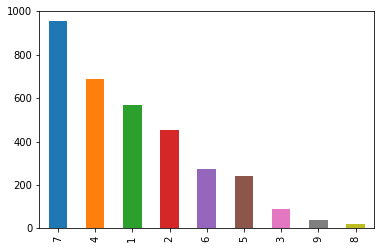

In [8]:
train_data['Class'].value_counts().plot(kind = 'bar')

The labels are very imbalanced. For model evaluation part I will use matrics to deal with this imbalance. 

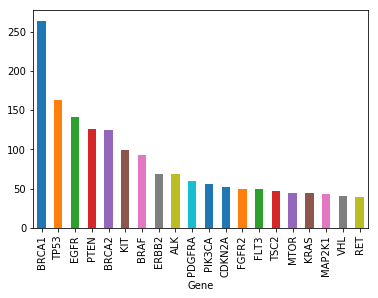

In [9]:
top20_gene = train_data.groupby('Gene').size().sort_values(ascending = False).head(20)
top20_gene.plot(kind='bar')

Gene BRCA1 is most prevelant in cancers, account approximately 8% of all the cases. 

In [10]:
def clean_text(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", str(text))
    text = text.lower().split()
    stop_words = {'so', 'his', 't', 'y', 'ours', 'herself', 
             'your', 'all', 'some', 'they', 'i', 'of', 'didn', 
             'them', 'when', 'will', 'that', 'its', 'because', 
             'while', 'those', 'my', 'don', 'again', 'her', 'if',
             'further', 'now', 'does', 'against', 'won', 'same', 
             'a', 'during', 'who', 'here', 'have', 'in', 'being', 
             'it', 'other', 'once', 'itself', 'hers', 'after', 're',
             'just', 'their', 'himself', 'theirs', 'whom', 'then', 'd', 
             'out', 'm', 'mustn', 'where', 'below', 'about', 'isn',
             'shouldn', 'wouldn', 'these', 'me', 'to', 'doesn', 'into',
             'the', 'until', 'she', 'am', 'under', 'how', 'yourself',
             'couldn', 'ma', 'up', 'than', 'from', 'themselves', 'yourselves',
             'off', 'above', 'yours', 'having', 'mightn', 'needn', 'on', 
             'too', 'there', 'an', 'and', 'down', 'ourselves', 'each',
             'hadn', 'ain', 'such', 've', 'did', 'be', 'or', 'aren', 'he', 
             'should', 'for', 'both', 'doing', 'this', 'through', 'do', 'had',
             'own', 'but', 'were', 'over', 'not', 'are', 'few', 'by', 
             'been', 'most', 'no', 'as', 'was', 'what', 's', 'is', 'you', 
             'shan', 'between', 'wasn', 'has', 'more', 'him', 'nor',
             'can', 'why', 'any', 'at', 'myself', 'very', 'with', 'we', 
             'which', 'hasn', 'weren', 'haven', 'our', 'll', 'only',
             'o', 'before','1','2','p','expression','mutants','cells','cancer',
             'binding','protein','activity','cbl','patient','c-cbl','fig',
             'stability','effect','samples','mutations','cell','cases','evidence',
             'gene','demonstrated','recent','frequent','acquired','ret','introduction',
             ' abstract', 'mechanism','oncogenic','novel','found','many'}
    
    # stop words from nltk library
    stop_words_nltk = set(stopwords.words('english'))
    
    text = [w for w in text if not w in stop_words]  
    text = [w for w in text if not w in stop_words_nltk]
    text = " ".join(text)
    text = text.replace("."," ").replace(","," ")
    
    
    return(text)

In [11]:
train_clean = []
for txt in train_data['Text']:
    new_text = clean_text(txt)
    train_clean.append(new_text)
train_data['cleaned_text'] = train_clean


In [12]:
test_clean = []
for txt_test in test_data['Text']:
    new_text_test = clean_text(txt_test)
    test_clean.append(new_text_test)
test_data['cleaned_text'] = test_clean

Text(0.5,1,'Top Twenty Counts of Most-Common Words Among Text')

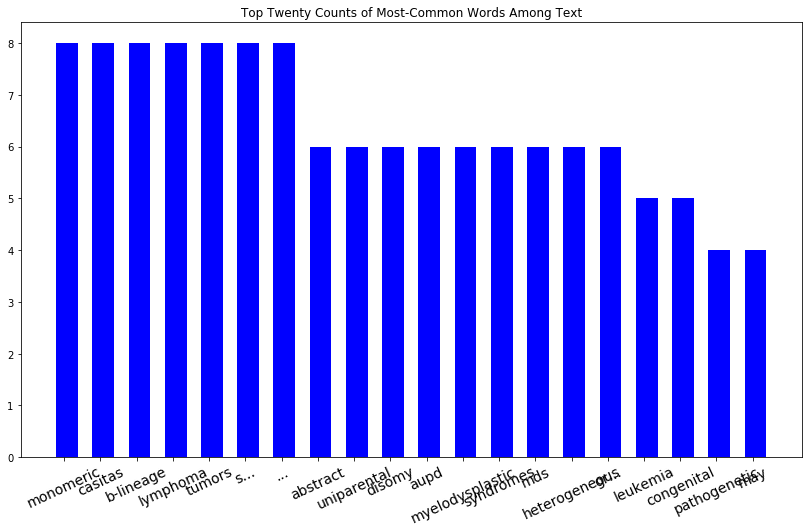

In [13]:
tops = Counter(str(train_data['cleaned_text']).split()).most_common()[:20]
labs, vals = zip(*tops)
idx = np.arange(len(labs))
wid=0.6
fig, ax=plt.subplots(1,1,figsize=(14,8))
ax=plt.bar(idx, vals, wid, color='b')
ax=plt.xticks(idx - wid/8, labs, rotation=25, size=14)
plt.title('Top Twenty Counts of Most-Common Words Among Text')

In [47]:
from sklearn.model_selection import StratifiedShuffleSplit

X = train_data[['cleaned_text']]
y = train_data['Class']

x_train, x_val, y_train, y_val\
    = train_test_split(X, y, test_size=0.2, random_state=1)



Here, a pipeline is created to process CountVectorizer, TfidfTransformer, and Naive Bayes.

TF-IDF score represents the relative importance of a term in the document and the entire corpus. TF-IDF score is composed by two terms: the first computes the normalized Term Frequency (TF), the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

TF = (Number of times term t appears in a document) / (Total number of terms in the document)
IDF = log_e(Total number of documents / Number of documents with term t in it)

### Naive Beyasian Model

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


text_clf_nb = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer(use_idf = False)),
                     ('clf', MultinomialNB(alpha=0.001))])

text_clf_nb = text_clf_nb.fit(x_train['cleaned_text'], y_train)

In [52]:
from sklearn import metrics
y_pred = text_clf_nb.predict(x_val['cleaned_text'])
print(metrics.classification_report(y_val, y_pred))


             precision    recall  f1-score   support

          1       0.53      0.61      0.57       107
          2       0.60      0.46      0.52        98
          3       0.50      0.36      0.42        22
          4       0.80      0.64      0.71       141
          5       0.35      0.44      0.39        45
          6       0.68      0.52      0.59        48
          7       0.68      0.83      0.75       192
          8       1.00      0.25      0.40         4
          9       0.70      0.88      0.78         8

avg / total       0.64      0.63      0.63       665



Let's try if we can improve the performance by using linearSVC

### Linear SVC

In [53]:
from sklearn.svm import SVC

text_clf_svc = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                     ('clf-svc', SVC(kernel = 'linear'))])

text_clf_svc = text_clf_svc.fit(x_train['cleaned_text'], y_train)

In [54]:
y_pred_svc = text_clf_svc.predict(x_val['cleaned_text'])
print(metrics.classification_report(y_val, y_pred_svc))

             precision    recall  f1-score   support

          1       0.53      0.61      0.57       107
          2       0.70      0.34      0.46        98
          3       0.25      0.05      0.08        22
          4       0.72      0.67      0.69       141
          5       0.38      0.40      0.39        45
          6       0.81      0.52      0.63        48
          7       0.64      0.90      0.74       192
          8       1.00      0.25      0.40         4
          9       0.70      0.88      0.78         8

avg / total       0.63      0.63      0.61       665



The performance by using Linear SVC is similar to Naive Bayes. In the future, the model could be further improved by word2vec, LSTM to consider the structure of sentences. 